In [ ]:
!pip install tensorflow==2.12
!pip install tensorflow_hub
!pip install git+https://github.com/tensorlayer/tensorlayerx.git


  Using cached tensorflow-2.15.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.2 kB)
  Using cached ml_dtypes-0.3.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (20 kB)
  Using cached tensorboard-2.15.2-py3-none-any.whl.metadata (1.7 kB)
  Using cached tensorflow_estimator-2.15.0-py2.py3-none-any.whl.metadata (1.3 kB)
  Using cached keras-2.15.0-py3-none-any.whl.metadata (2.4 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 37.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 68.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 103.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 30.9 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.12.0
    Uninstalling tensorflow-estimator-2.12.0:
      Successfully unins

In [ ]:
import os
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras import layers

In [ ]:
# Create a directory to store the DIV2K dataset
!mkdir -p DIV2K

# Download the necessary parts of the DIV2K dataset
!wget -O DIV2K/DIV2K_train_HR.zip https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip
!wget -O DIV2K/DIV2K_train_LR_bicubic_X4.zip https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_LR_bicubic_X4.zip
!wget -O DIV2K/DIV2K_valid_HR.zip https://data.vision.ee.ethz.ch/cvl/DIV2K/validation_release/DIV2K_valid_HR.zip
!wget -O DIV2K/DIV2K_valid_LR_bicubic_X4.zip https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_LR_bicubic_X4.zip

# Unzip the downloaded files
!unzip DIV2K/DIV2K_train_HR.zip -d DIV2K/DIV2K_train_HR
!unzip DIV2K/DIV2K_train_LR_bicubic_X4.zip -d DIV2K/DIV2K_train_LR_bicubic
!unzip DIV2K/DIV2K_valid_HR.zip -d DIV2K/DIV2K_valid_HR
!unzip DIV2K/DIV2K_valid_LR_bicubic_X4.zip -d DIV2K/DIV2K_valid_LR_bicubic


--2024-11-27 12:31:28--  https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip
Resolving data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)... 129.132.52.178, 2001:67c:10ec:36c2::178
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3530603713 (3.3G) [application/zip]
Saving to: ‘DIV2K/DIV2K_train_HR.zip’

DIV2K/DIV2K_train_H 100%[===================>]   3.29G  29.6MB/s    in 1m 57s  

2024-11-27 12:33:26 (28.7 MB/s) - ‘DIV2K/DIV2K_train_HR.zip’ saved [3530603713/3530603713]

--2024-11-27 12:33:26--  https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_LR_bicubic_X4.zip
Resolving data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)... 129.132.52.178, 2001:67c:10ec:36c2::178
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 246914039 (235M) [application/zip]
Saving to: ‘DIV2K/DIV2K_train_LR

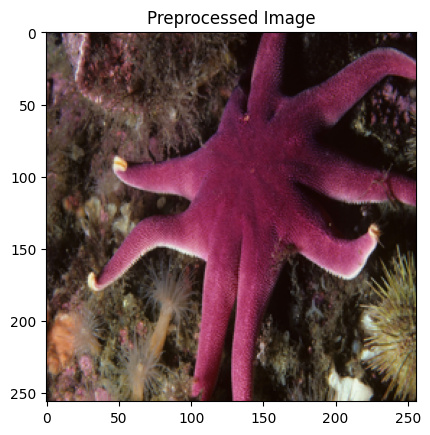

In [ ]:
def preprocess_image(image_path, target_size=(256, 256)):
    """Resize and normalize images"""
    image = Image.open(image_path)
    image = image.resize(target_size)
    image = np.array(image) / 255.0  # Normalize pixel values to [0, 1]
    return image

# Example usage
image_path = '/content/DIV2K/DIV2K_train_HR/DIV2K_train_HR/0001.png'  # Example image
processed_image = preprocess_image(image_path)

plt.imshow(processed_image)
plt.title('Preprocessed Image')
plt.show()


In [ ]:
def residual_block(x, filters, kernel_size=3):
    """Residual block used in the ESRGAN generator"""
    res = layers.Conv2D(filters, kernel_size, padding='same')(x)
    res = layers.ReLU()(res)
    res = layers.Conv2D(filters, kernel_size, padding='same')(res)
    return layers.add([x, res])

def build_generator(input_shape=(256, 256, 3)):
    """Generator model of ESRGAN"""
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(64, 9, padding='same')(inputs)
    x = layers.ReLU()(x)

    # Add residual blocks
    for _ in range(16):
        x = residual_block(x, 64)

    x = layers.Conv2D(64, 3, padding='same')(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(3, 9, padding='same', activation='sigmoid')(x)  # Output layer
    return tf.keras.Model(inputs, x)

generator = build_generator()
generator.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 64)   │         15,616 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu (ReLU)              │ (None, 256, 256, 64)   │              0 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 256, 256, 64)   │         36,928 │ re_lu[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_1 (ReLU)            │ (None, 256, 256, 64)   │              0 │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 256, 256, 64)   │         36,928 │ re_lu_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 256, 256, 64)   │              0 │ re_lu[0][0],           │
│                           │                        │                │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 256, 256, 64)   │         36,928 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_2 (ReLU)            │ (None, 256, 256, 64)   │              0 │ conv2d_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 256, 256, 64)   │         36,928 │ re_lu_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 256, 256, 64)   │              0 │ add[0][0],             │
│                           │                        │                │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 256, 256, 64)   │         36,928 │ add_1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_3 (ReLU)            │ (None, 256, 256, 64)   │              0 │ conv2d_5[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 256, 256, 64)   │         36,928 │ re_lu_3[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_2 (Add)               │ (None, 256, 256, 64)   │              0 │ add_1[0][0],           │
│                           │                        │                │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 256, 256, 64)   │         36,928 │ add_2[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_4 (ReLU)            │ (None, 256, 256, 64)   │              0 │ conv2d_7[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 256, 256, 64)   │         36,928 │ re_lu_4[0][0]          │
├──────────────────────

 Total params: 1,249,795 (4.77 MB)

 Trainable params: 1,249,795 (4.77 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
def pixel_loss(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true - y_pred))

# Perceptual loss can be added by using a pretrained VGG model
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet', input_shape=(256, 256, 3))
vgg.trainable = False
vgg_output = vgg.get_layer('block5_conv4').output
vgg_model = tf.keras.Model(inputs=vgg.input, outputs=vgg_output)

def perceptual_loss(y_true, y_pred):
    return tf.reduce_mean(tf.square(vgg_model(y_true) - vgg_model(y_pred)))


In [ ]:
def pixel_loss(y_true, y_pred):
    # Ensure both tensors are of the same type (e.g., float32)
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    return tf.reduce_mean(tf.square(y_true - y_pred))


In [ ]:
def build_discriminator(input_shape=(256, 256, 3)):
    """Discriminator model of ESRGAN"""
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(64, 3, padding='same')(inputs)
    x = layers.LeakyReLU(0.2)(x)

    # Add more convolution layers to discriminate
    for _ in range(3):
        x = layers.Conv2D(64, 3, padding='same')(x)
        x = layers.LeakyReLU(0.2)(x)

    x = layers.Conv2D(1, 3, padding='same', activation='sigmoid')(x)
    return tf.keras.Model(inputs, x)

discriminator = build_discriminator()
discriminator.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_35 (Conv2D)                   │ (None, 256, 256, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 256, 256, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_36 (Conv2D)                   │ (None, 256, 256, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 256, 256, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_37 (Conv2D)                   │ (None, 256, 256, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 256, 256, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_38 (Conv2D)                   │ (None, 256, 256, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 256, 256, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_39 (Conv2D)                   │ (None, 256, 256, 1)         │             577 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 113,153 (442.00 KB)

 Trainable params: 113,153 (442.00 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Optimizers
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

@tf.function
def train_step(lr_image, hr_image):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        fake_hr = generator(lr_image, training=True)

        real_output = discriminator(hr_image, training=True)
        fake_output = discriminator(fake_hr, training=True)

        gen_loss = pixel_loss(hr_image, fake_hr) + perceptual_loss(hr_image, fake_hr)
        disc_loss = -tf.reduce_mean(tf.math.log(real_output + 1e-12) + tf.math.log(1 - fake_output + 1e-12))

    # Gradients for generator and discriminator
    generator_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))

    return gen_loss, disc_loss

# Example train step
lr_image = tf.convert_to_tensor(processed_image[None, ...])  # Convert to tensor with batch dimension
hr_image = lr_image  # Use the same image for testing

gen_loss, disc_loss = train_step(lr_image, hr_image)
print("Generator Loss: ", gen_loss.numpy(), "Discriminator Loss: ", disc_loss.numpy())


Generator Loss:  0.20054758 Discriminator Loss:  1.3960422


In [ ]:
pip install pillow


In [ ]:
from PIL import Image
from google.colab import files

def enhance_image(lr_image):
    # Resize the image (4x upscale)
    return lr_image.resize((lr_image.width * 4, lr_image.height * 4), Image.BICUBIC)

def upload_and_enhance():
    # Upload image using Google Colab's file upload
    uploaded = files.upload()
    for filename in uploaded.keys():
        print(f"Uploaded file: {filename}")

        lr_image = Image.open(filename)  # Open the image file
        lr_image.show()  # Show the low-res image (optional)

        # Enhance the image (increase resolution)
        hr_image = enhance_image(lr_image)

        # Show the high-res image
        hr_image.show()

        # Save the high-res image
        hr_image.save(f"enhanced_{filename}")
        print(f"High-resolution image saved as enhanced_{filename}")

# Run the function to upload and enhance the image
upload_and_enhance()


Saving 8.jpg to 8.jpg
Uploaded file: 8.jpg
High-resolution image saved as enhanced_8.jpg
